In [1]:
import pandas as pd
import math
import re
import spacy
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
tweets1_1 = pd.read_csv("./data/hashtag_donaldtrump.csv", lineterminator="\n")
tweets1_2 = pd.read_csv("./data/hashtag_joebiden.csv", lineterminator="\n")
tweets2_1 = pd.read_csv("./data/2020-US-election-tweets.csv", sep=",")

In [4]:
tweets = pd.DataFrame()

In [5]:
def parser (tweet, likes, retweets, date):
    """ La funcion estandariza los tipos de datos con los que se va a trabajar ... 
        args:
            tweet (): object
            likes(): numeric
            retweets(): numeric
            date (): object
        return : DataFrame
    """
    df = pd.DataFrame({'tweet': tweet.astype(str), 
                       'likes':likes.astype('int64'), 
                       'retweets': retweets.astype('int64'), 
                       'date': pd.to_datetime(date, errors='coerce').dt.date})
    return df    

In [6]:
tweets = tweets.append(parser(tweets1_1['tweet'], tweets1_1['likes'], tweets1_1['retweet_count'], tweets1_1['created_at']))
tweets = tweets.append(parser(tweets1_2['tweet'], tweets1_2['likes'], tweets1_2['retweet_count'], tweets1_2['created_at']))
tweets = tweets.append(parser(tweets2_1['tweet'], tweets2_1['likes_count'], tweets2_1['retweets_count'], tweets2_1['date']))

In [7]:
tweets = tweets.sort_values('date', ascending=False)

In [8]:
def clean(text):
    """ La funcion elimina los caracteres especiales, links, saltos de linea, tabulaciones, signos de puntuacion ... 
        
        args:
            text (): str
        return : str
    """
    text = str(text).lower()
    text = re.sub('[\.,/#@!$|%^&*;:{}=-_`~[]()”“"…?!@'']', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'#','',text)
    text=re.sub(r'rt[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    text = re.sub("[^a-z0-9\\s]","", text)
    return text

In [9]:
tweets['tweet'] = tweets['tweet'].apply(lambda x: clean(x))
tweets.to_csv("./data/tweets.csv", sep=',', index=False)

In [10]:
qtt = 10000
nlp = spacy.load('en_core_web_sm')
doc = nlp(tweets['tweet'].head(qtt).to_string())
stop_words = [token.text for token in doc if token.is_stop]
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [11]:
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words[:qtt])
common_words = word_freq.most_common()

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list, qtty):
    """ La funcion grafica la cantidad de ocurrencias con mayor repeticion ... 
        
        args:
            wd_list (): pd.Series
            qtty (): int
        return : none
    """
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=qtty,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

def tweets_candidate(tweet, candidate) :
    count = 0
    for text in tweet.iteritems():
        if candidate in text: 
           count =+ 1
    return count

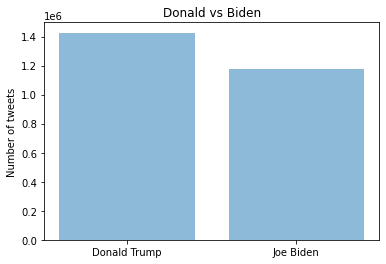

In [13]:
# Numero de tweets que menciona Donald Trump -- grafico de barras
trump_tweets = tweets[tweets.tweet.str.contains(pat='trump', case=False)]
biden_tweets = tweets[tweets.tweet.str.contains(pat='biden', case=False)]

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [trump_tweets.shape[0],biden_tweets.shape[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald vs Biden')

plt.show()

In [14]:
# Cantidad de menciones a traves del tiempo para cada candidato-- grafico de lineas
trump_tweets['date2'] = trump_tweets['date'].apply(lambda d: str(d.day)+"-"+str(d.month))
biden_tweets['date2'] = biden_tweets['date'].apply(lambda d: str(d.day)+"-"+str(d.month))
mencions_month_trump = trump_tweets.groupby(trump_tweets['date2']).apply(lambda x: pd.Series({
        'trump': x.tweet.count()
}))
mencions_month_biden = biden_tweets.groupby(biden_tweets['date2']).apply(lambda x: pd.Series({
        'biden': x.tweet.count()
}))

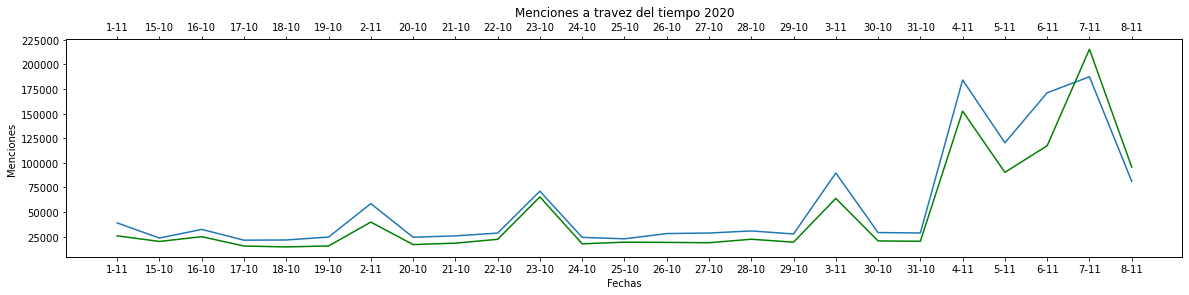

In [15]:
fig, ax1 = plt.subplots(figsize= (20,4))
 
ax1.plot(mencions_month_trump)
#Para poder realizar ambos plots en uno pero con diferentes escalas en el eje x, usamos twiny que nos permite compartir el eje y
ax2 = ax1.twiny()
ax2.plot(mencions_month_biden, color='g')
ax1.set_title("Menciones a travez del tiempo 2020")
ax1.set_xlabel("Fechas")
ax1.set_ylabel("Menciones")
plt.show()

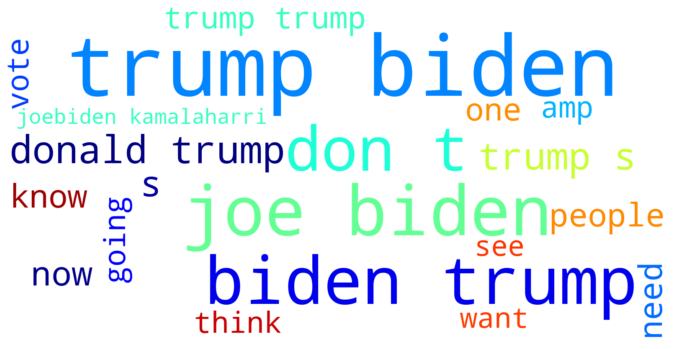

In [16]:
# Las 20 Palabras mas comunes
word_cloud(tweets['tweet'], 20)

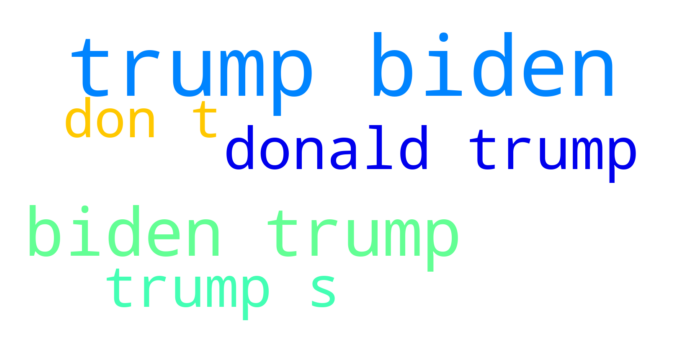

In [18]:
# 20 Palabras mas comunes para Donald Trump -- imshow
word_cloud(trump_tweets['tweet'], 5)

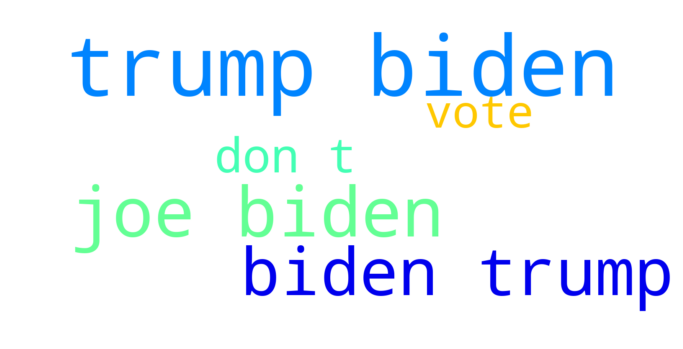

In [19]:
# 20 Palabras mas comunes para Joe Biden -- imshow
word_cloud(biden_tweets['tweet'], 5)